In [1]:
import numpy as np
# import tensorflow as tf
# tf.enable_eager_execution()
from keras.models import load_model
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

%matplotlib inline
import matplotlib.pyplot as plt
from vis.utils import utils
from vis.visualization import visualize_cam, visualize_saliency, visualize_activation, overlay

Using TensorFlow backend.


In [2]:
def default_categorical(input_dimension=(120,160,3)):

    img_in = Input(shape=(input_dimension), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(15, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0

    #continous output of throttle
    throttle_out = Dense(1, activation='relu', name='throttle_out')(x)      # Reduce to 1 number, Positive number only

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
    model.compile(optimizer='adam',
                  loss={'angle_out': 'categorical_crossentropy',
                        'throttle_out': 'mean_absolute_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': .001})

    return model

In [3]:
# model_type = 'baseline'
model_type = 'style_transfer'

if model_type == 'baseline':
    model_path = '/workspace/data/pix_baseline_4'
elif model_type == 'style_transfer':
    model_path = '/workspace/data/pix_baseline_transfer_all'
    
model = default_categorical()
model.load_weights(model_path)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 78, 24)   1824        img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 37, 32)   19232       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)    

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


7


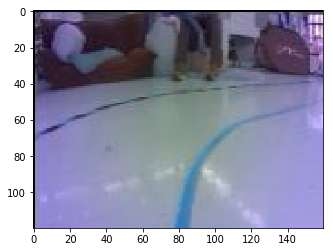

In [4]:
img = utils.load_img('/workspace/data/tub_05_25_centerlane/0_cam-image_array_.jpg', target_size=(120, 160))
plt.imshow(img)

input_array = np.array(img)
input_array = np.expand_dims(input_array, axis=0)
prediction = model.predict(input_array)[0]
pred_indices = np.argmax(prediction)
print(pred_indices)

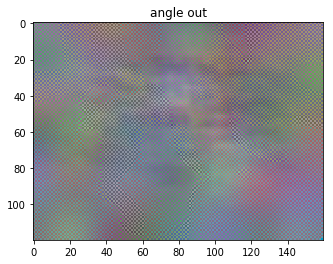

In [5]:
layer_idx = utils.find_layer_idx(model, 'angle_out')

act = visualize_activation(model, layer_idx, filter_indices=pred_indices)
plt.figure()
plt.title('angle out')
plt.imshow(act)
plt.show()

In [6]:
import matplotlib.cm as cm
from pathlib import Path

layer_idx = utils.find_layer_idx(model, 'angle_out')

save_folder_path = Path('/workspace/data/{}_cam_visualization'.format(model_type))
save_folder_path.mkdir(exist_ok=True, parents=True)



                        
# for img_fn in img
# for i in range(15):
#     heatmap = visualize_cam(model, layer_idx=layer_idx, filter_indices=i,
#                             seed_input=img)
#     heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)

#     #     grads = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=img)
#     plt.figure()
#     plt.title("{} angle output at category {}".format(model_type, i))
#     # Overlay is used to alpha blend heatmap onto img.
#     plt.imshow(overlay(img, heatmap, alpha=0.7))
#     fn = str(save_folder_path / "{}.png".format(i))
# #     plt.savefig(fn)

In [7]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML

def plot_movie_mp4(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [11]:
import keras.backend as K

def output_max_activation_map(img_num):
    model_type = 'style_transfer'

    if model_type == 'baseline':
        model_path = '/workspace/data/pix_baseline_4'
    elif model_type == 'style_transfer':
        model_path = '/workspace/data/pix_baseline_transfer_all'
        
    img_folder_path = Path('/workspace/data/tub_05_25_centerlane/')
    num_jpgs = len(list(img_folder_path.glob('*.jpg')))

    save_folder_path = Path('/workspace/data/{}_pred_heatmap_angle_out'.format(model_type))
    save_folder_path.mkdir(exist_ok=True, parents=True)

    K.clear_session()
    

    
    model = default_categorical()
    model.load_weights(model_path)
    img_fn = img_folder_path / '{}_cam-image_array_.jpg'.format(img_num)
    img = utils.load_img(img_fn, target_size=(120, 160))
    
    input_array = np.array(img)
    input_array = np.expand_dims(input_array, axis=0)
    prediction = model.predict(input_array)[0]
    pred_indices = np.argmax(prediction)
    
    heatmap = visualize_cam(model, layer_idx=layer_idx, filter_indices=pred_indices,
                            seed_input=img)
    heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)

    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(overlay(img, heatmap, alpha=0.7))
    plt.savefig(str(save_folder_path / '{}.png'.format(img_num)))
    plt.close(fig)
    print(img_num)

for img_num in range(num_jpgs):
    output_max_activation_map(img_num)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
print(len(img_fns))